In [202]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split

from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored


In [203]:
# Load data
data = pd.read_csv("data/Recurrence free survival in breast cancer patients.csv")

# Define variable types
CONTINUOUS_VARIABLES = ["age", "size", "nodes", "prog", "oest"]
CATEGORICAL_VARIABLES = ["treat", "men", "grade"]

# Scale continuous features
scaler = MinMaxScaler()
data[CONTINUOUS_VARIABLES] = scaler.fit_transform(data[CONTINUOUS_VARIABLES])

# One-hot encode categorical features (drop first to avoid multicollinearity)
data = pd.get_dummies(data, columns=CATEGORICAL_VARIABLES, drop_first=True)

In [204]:
#Data splitting

# Sort the full dataset by row order to preserve original "last 100 records"
data = data.reset_index(drop=True)

# Randomly select 200 rows from the dataset for training (mixed censored & uncensored)
DatTraining = data.sample(n=200, random_state=42)

# Use the remaining data as candidate for testing
DatTesting = data.drop(DatTraining.index)

# Filter testing data to only include uncensored samples
DatTesting = DatTesting[DatTesting["status"] == 1]



# Predictors
PREDS = ["age", "size", "nodes", "prog", "oest", "treat_1", "men_2", "grade_2", "grade_3"]
X_train = DatTraining[PREDS]
X_test = DatTesting[PREDS]

# Structured survival targets for sksurv
import numpy as np
y_train = np.array([(bool(e), t) for e, t in zip(DatTraining["status"], DatTraining["time"])],
                   dtype=[("event", "bool"), ("time", "float64")])

y_test = np.array([(bool(e), t) for e, t in zip(DatTesting["status"], DatTesting["time"])],
                  dtype=[("event", "bool"), ("time", "float64")])

In [205]:
#Train model
rsf = RandomSurvivalForest(n_estimators = 100
,min_samples_split = 2
,min_samples_leaf = 2
,max_features = 1
,max_depth = 10
,random_state = 42)


rsf.fit(X_train, y_train)

RandomSurvivalForest(max_depth=10, max_features=1, min_samples_leaf=2,
                     min_samples_split=2, random_state=42)

In [206]:
#Predict RMSE,C-score,survival function and get the corresponding time grid
surv_train = rsf.predict_survival_function(X_train)
surv_test = rsf.predict_survival_function(X_test)

# Use the time grid from the first survival function (they all share the same)
time_grid = surv_train[0].x

# Function to compute median survival time
def get_median_survival_time(surv_funcs, times):
    medians = []
    for fn in surv_funcs:
        surv_probs = fn(times)
        below_50 = np.where(surv_probs < 0.5)[0]
        if len(below_50) == 0:
            medians.append(times[-1])
        else:
            medians.append(times[below_50[0]])
    return np.array(medians)

# Get predicted median times
yhat_train = get_median_survival_time(surv_train, time_grid)
yhat_test = get_median_survival_time(surv_test, time_grid)



In [207]:
#Print evaluations
c_train = concordance_index_censored(DatTraining["status"].astype(bool), DatTraining["time"], yhat_train)[0]
c_test = concordance_index_censored(DatTesting["status"].astype(bool), DatTesting["time"], yhat_test)[0]

print(f"C-index (Train): {c_train:.4f}")
print(f"C-index (Test):  {c_test:.4f}")

# RMSE
rmse_train = root_mean_squared_error(DatTraining["time"], yhat_train)
rmse_test = root_mean_squared_error(DatTesting["time"], yhat_test)

print(f"RMSE (Train): {rmse_train:.4f}")
print(f"RMSE (Test):  {rmse_test:.4f}")


C-index (Train): 0.0842
C-index (Test):  0.4330
RMSE (Train): 976.3161
RMSE (Test):  1279.0109


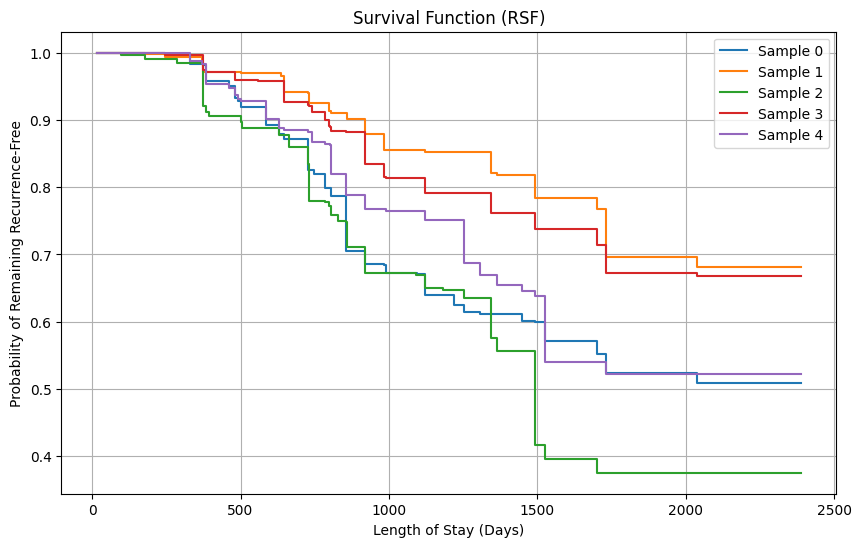

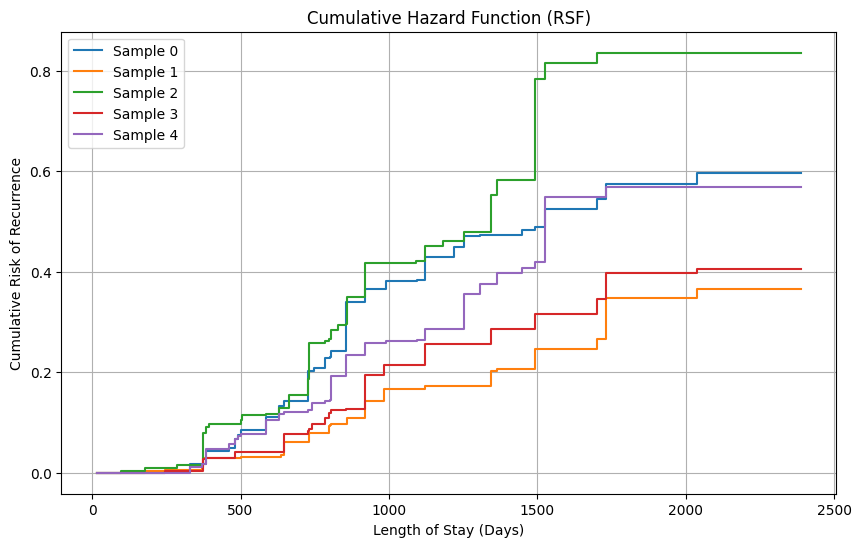

In [201]:
import matplotlib.pyplot as plt

# Select a few test samples for plotting
X_test_sel = X_test.iloc[:5]

# --- Plot Survival Functions ---
surv = rsf.predict_survival_function(X_test_sel, return_array=True)

plt.figure(figsize=(10, 6))
for i, s in enumerate(surv):
    plt.step(rsf.unique_times_, s, where="post", label=f"Sample {i}")
plt.ylabel("Probability of Remaining Recurrence-Free")
plt.xlabel("Length of Stay (Days)")
plt.title("Survival Function (RSF)")
plt.legend()
plt.grid(True)
plt.show()

# --- Plot Cumulative Hazard Functions ---
haz = rsf.predict_cumulative_hazard_function(X_test_sel, return_array=True)

plt.figure(figsize=(10, 6))
for i, h in enumerate(haz):
    plt.step(rsf.unique_times_, h, where="post", label=f"Sample {i}")
plt.ylabel("Cumulative Risk of Recurrence")
plt.xlabel("Length of Stay (Days)")
plt.title("Cumulative Hazard Function (RSF)")
plt.legend()
plt.grid(True)
plt.show()
